# <font size="10"><span style='color:#2a4b8d'><p style="text-align: center;">A short guide on where to safely eat delicious food in Chicago</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import re

**Requirements**

The project repo contains a notebook with data collection and descriptive analysis, properly commented, and the notebook ends with a more structured and informed plan for what comes next (all the way to a plan for the presentation). These sections of the notebook should be filled in by milestone 3.

We will evaluate this milestone according to how well these previous steps (or other reasonable ones) have been done and documented, the quality of the code and its documentation, the feasibility and critical awareness of the project.

# Data collection

- That you can handle the data in its size.

## Chicago Food Inspections (CFI) dataset

This is our main [dataset](https://www.kaggle.com/chicago/chicago-food-inspections), where the information is derived from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program using a standardized procedure. This dataset contains 22 columns and 194’615 rows (updated frequently, so subject to change). 

In [2]:
cfi = pd.read_csv('data/chicago-food-inspections/food-inspections.csv')
print('The dataset has size: ', cfi.shape)

The dataset has size:  (194784, 22)


## Yelp Reviews (YR) dataset

Yelp.com is a website that helps people find great local businesses such as restaurants based on customer reviews. Each business has a page where visitors can write comments and add a general grade reflecting their experience there. We can conveniently access these business ratings through their Yelp Fusion API for all businesses with at least one review. The API also gives us other relevant information such as the number of reviews, which will be a factor taken into account while ranking the restaurants. Moreover, it is possible to search for the businesses via their latitude and longitude location data, which is of great interest in our project framework, as our main CFI dataset contains the latitude and longitude of the restaurants as well. A more detailed description of the API can be found [here](https://www.yelp.com/developers/documentation/v3/business_search).

## Crimes dataset

This [dataset](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2) reflects reported incidents of crime that occurred in the City of Chicago from 2001 to present, and is updated daily with a seven-day lag. For our project, we will however only focus on the data from January 1, 2010 onwards to match with the CFI dataset. Data is extracted from the Chicago Police Department's CLEAR system and due to privacy concerns, addresses are only shown at the block level. This level of resolution is however more than sufficient for the analyses we aim to undertake. 

In [3]:
#crimes = pd.read_csv('data/crimes.csv')

---

# Data preprocessing

- That you understand what’s into the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.

## Chicago Food Inspections (CFI) dataset

Note that the last 5 columns only contain NaN values, and will therefore be removed from the dataset. The set is in a simple csv file, which makes it easy to read using Pandas. By quickly inspecting the dataset on Pandas, we can note that there are 121 duplicates, which is only a tiny fraction of the data compared to the number of rows, ensuring we will have enough data to work with. In this dataset, we have information on the location of the restaurants, where 7 columns contain spatial indicators, excluding the columns on the community area and zip codes, which are full of NaN values and will hence be disregarded. Information on the inspections consist of 5 columns including the inspection type, date, id, results and possible violations. The remaining columns are related to the restaurant itself, including the facility type, licence number, DBA, AKA names and risk.

### 1. Exploring columns

In [4]:
# Drop columns that only contain NaNs
cfi.drop(columns = ['Historical Wards 2003-2015', 'Zip Codes', 'Community Areas', 'Census Tracts', 'Wards'], inplace = True)

# Remove inspection for which buisnesses were closed or not found
cfi = cfi[(cfi['Results'] != 'Out of Business') & (cfi['Results'] != 'Business Not Located')]

# Remove buisnesses without any license number
cfi = cfi[(cfi['License #'] != 0)]

### 2. Facility inspection

We only want to select inspections on facilities that prepare the food themselves. That is, we want to exclude grocery stores, gas stations, schools, etc. 

In [5]:
# Initializing the regex 
REST = "rest|diner|sushi|taqueria|hot.dog|grill|cuisine|jap.nese|sandwich|bbq|pizza|burrito|mcdo|mc do|kimchee|chicken|pollo|fish|pasta|taco|rice|fast.food|bagel|noodle|sub|pita|kebab|kabob|seafood|shrimp|thai|african|chinese|burger|porkchop|wendy"
BAR = "bar|hooka|bistro|brewery"
TAVERN = "tavern"
COFFEE = "cafe|caffe|coffee"
DESSERT = "gelato|ice.cream|paleteria|dessert|cand.|chocolate|cookies|cake|patisserie|sweet"
BAKERY = "bakery|donut"
DRINKS = "shake|juice|smoothie|tea"
SNACK = "snack|snak|popcorn"
DELI = "deli"
regexes = [REST, BAR, TAVERN, COFFEE, DESSERT, BAKERY, DRINKS, SNACK, DELI]
types = ['Restaurant', 'Bar', 'Tavern', 'Coffee', 'Dessert', 'Bakery', 'Drinks', 'Snaks', 'Deli']

# Get rows with no facility type
no_facility = cfi['Facility Type'].isnull() 

# Change the facility type according to the regexes
for i, regex in enumerate(regexes):
    facility = cfi['Facility Type'].str.contains(pat = regex, case=False, regex=True, na=False)
    dba = cfi['DBA Name'].str.contains(pat = regex, case = False, regex = True, na=False)
    cfi.loc[facility|(no_facility & dba), 'Facility Type'] = types[i]
    
# Drop rows with no and not of interest facility type
cfi.dropna(axis = 0, subset = ['Facility Type'], inplace = True)
index_names = cfi[~cfi['Facility Type'].isin(types)].index
cfi.drop(index_names, inplace = True)

### 3. Locations inspection

There are no rows that don't have one of either latitude, longitude and address. The address, however, is insufficient, and thus all samples without latitude & longitude will be removed.

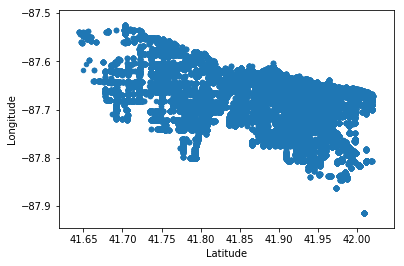

In [6]:
# Drop location with missing latitude or longitude
no_location = cfi[cfi['Latitude'].isnull() | cfi['Longitude'].isnull()].index
cfi.drop(no_location, inplace = True)

# Plot the locations
cfi.plot.scatter(x = 'Latitude', y ='Longitude')
plt.show()

This scatter plot shows that all of the data does seem to really be in Chicago.

### 4. Group places

In [7]:
import datetime

# Drop unused columns
cfi.drop(columns = ['AKA Name', 'Location'], inplace = True)

# Convert Inspection date in date format
cfi['Inspection Date'] = cfi['Inspection Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))

# Generate groups according to license number
groups = cfi.groupby(['License #'])

# Aggregates other columns either in a list format or by taking the mode
columns = (list(cfi.columns))
columns.remove('License #')
columns_to_list = ['Inspection ID', 'Inspection Date', 'Inspection Type', 'Results', 'Violations']

for i, col in enumerate(columns):
    if(col not in columns_to_list): # Take the mode value
        df = groups[col].agg(pd.Series.mode).reset_index(name=col)
    else: # Aggregate the resluts in a list
        df = groups[col].apply(list).reset_index(name=col)
        
    if(i==0):
        cfi_groups = df
    else:
        cfi_groups = cfi_groups.merge(df, on = ['License #'])

## Crimes dataset

The whole dataset includes almost 7M entries and 30 columns, but only roughly 3M entries pertain to our study period. The columns contain information regarding the time and type of the incidence (using the Illinois Uniform Crime Reporting code, IUCR). It also reports various location measures at different aggregation levels, where the latitude and longitude as well as the community area code will be of greatest importance for our intended analysis framework.

eliane

## Yelp Reviews (YR) dataset

jeremie

---

# Descriptive analysis 

Our research questions defined in the README give us a good framework for our descriptive analysis.

Up to the second milestone, we aimed to:

- evolution of the food inspection results
- food chains / food categories (type of cuisine, facility type etc.)
- a possible correlation of hygienic standards of the food places and their respective customer reviews
- patterns of neighborhood crime rates

## Evolution of food inspection results

camille

How did the food safety in Chicago evolve geographically since the year 2010? Does the same area/restaurants remain safe over time?

## Analysis of food chains and categories

hugues

Are large food chains or specific cuisine types more prone to fail food inspections?

## Correlation analysis  of hygienic standards of the food places and customer reviews

(jeremie)

Are there correlates between the food inspection fail rate of areas and online Yelp ratings of restaurants?

## Patterns of neighborhood crime rates

eliane

---

**We will finalize our descriptive analysis until milestone 3 by also doing:**

- Correlation analysis: Are there correlates between the food inspection fail rate of areas and online Yelp ratings of restaurants?
- Concluding analysis:
    - Where can one safely eat delicious food in Chicago?
    - Do certain neighborhoods offer a better overall dining experience based on customer reviews, and food as well as neighborhood safety?


## <span style='color:Gray'> Correlation analysis of hygienic standards and public safety

<span style='color:Gray'> Are there correlates between the food inspection fail rate of areas and public safety, measured through crime rates?

## <span style='color:Gray'> Concluding analysis

<span style='color:Gray'>
    
- Where can one safely eat delicious food in Chicago?
    
- Do certain neighborhoods offer a better overall dining experience based on customer reviews, and food as well as neighborhood safety?


---

# Project pipeline

- That you have updated your plan in a reasonable way, reflecting your improved knowledge after data acquaintance. In particular, discuss how your data suits your project needs and discuss the methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is now reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

## Mid-term review

## Internal milestones

**Due by Friday, Nov 29**



**Due by Friday, Dec 06**



**Due by Friday, Dec 13**



**Due by Friday, Dec 20 - Project deadline**
- to hand in: data story in a platform of your choice (e.g., a blog post, or directly in GitHub), plus the final notebook (continuation of milestone 2).


**Due by Monday, Jan 20 - Poster presentation**



# update readme!!!